# Portfolio 2: Analysing COVID-19 Data

We'll look at the most relevant dataset to our lives at the moment: the global spread of COVID-19.   There is an open dataset avaialable that is updated often showing the number of cases in different regions of the world.  This is the source of the graphs and visualisations that you'll see on the news. 

Here are some sample stories for reference:

* [From the ABC](https://www.abc.net.au/news/2020-03-26/coronavirus-covid19-global-spread-data-explained/12089028)
* [From the Guardian](https://www.theguardian.com/australia-news/datablog/ng-interactive/2020/apr/06/coronavirus-cases-in-australia-map-curve-confirmed-numbers-stats-how-many-covid-19-nsw-by-postcode-maps-victoria-live-data-qld-sa-wa-tas-nt-act-latest-statistics)
* [Coronavirus in Australia](https://www.covid19data.com.au/)
* [ArcGIS Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) Johns Hopkins


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

## Getting the Data

The first step is we get a copy of the raw data.  The data is being made available by Johns Hopkins University in [this GitHub repository](https://github.com/CSSEGISandData/COVID-19). We're interestd in the global confirmed cases dataset.  

We read the URL of the data to get live updates

In [0]:
# load the live dataset, assumes a working network connection
covid_data_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid = pd.read_csv(covid_data_url)

In [62]:
covid.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25


## Explore the Data

The format of this data is one row per geographical region with columns for Lat/Long and then one column for each day's data.  Most regions are countries but in some cases, as in Australia, they are states.  

For the analysis we want to do we'll look at data for countries only, so the first operation on the data frame is to combine all of the rows for countries like Australia that are split into states.  We then want to drop the non-numeric columns to leave us with just the numbers on each day for each country.  This can be done using the [`groupby`](https://pandas.pydata.org/docs/getting_started/10min.html#grouping) method and the [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method.  We can use these to make a new dataframe containing just the numerical data.

In [64]:
grouped = covid.groupby('Country/Region').sum()
grouped = grouped.drop(columns=['Lat', 'Long'])

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38,38,39,41,44,47,48,52,59,59,59,84,91,98,109,116,119,134,161,194,217,237,254,261,263,263,267,268,290,308,308,374,374,402,418,437,449,466,474,480
Western Sahara,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6
Yemen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


You can now select just the data for one country [using the `loc` method](https://pandas.pydata.org/docs/getting_started/10min.html#selection) since the new dataframe will have the grouped values (Countries) as the row labels. 

Select the data for one country and plot it. There clearly is a exponential rise in case numbers over time.

Text(0, 0.5, 'Case Count')

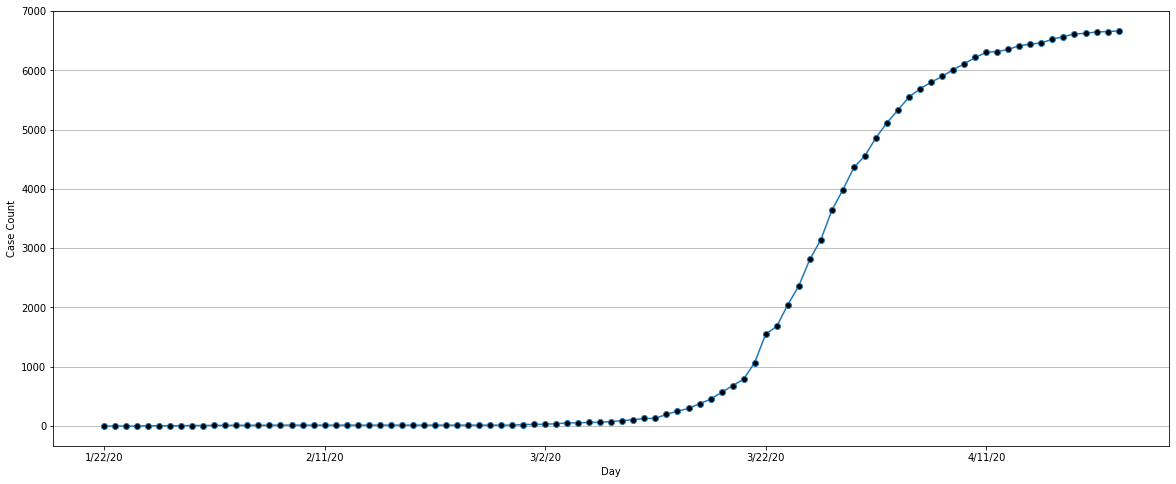

In [65]:
ax = grouped.loc['Australia'].plot(figsize=(20,8),marker='o',markerfacecolor='black',yticks=np.arange(0, grouped.loc['Australia'].max()+1000,1000))
ax.yaxis.grid()
ax.set_xlabel("Day")
ax.set_ylabel("Case Count")

## Comparing Countries

One of the classic displays in the news is the comparison between countries.  We select a number of countries (here, China, USA, Italy, UK, Australia) and plot their data on the same graph to reproduce a visualisation.

The visualisation shows the data for different countries aligned from the time that they have 100 confirmed cases.

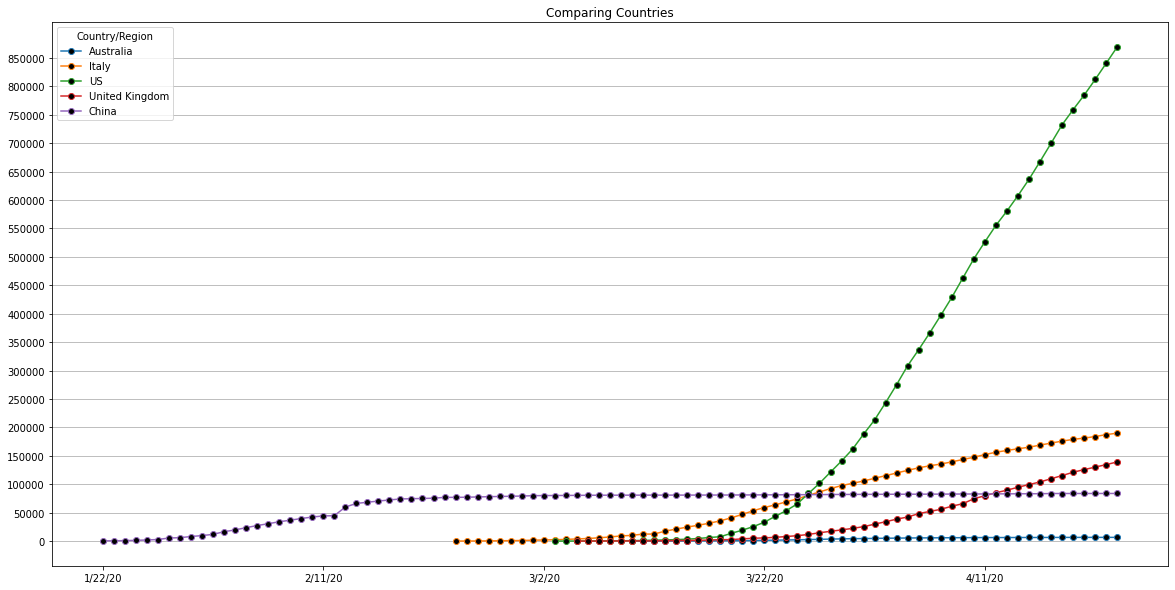

In [66]:
ax = grouped.loc[['Australia','Italy','US','United Kingdom','China']][grouped > 100].T.plot(figsize=(20,10), marker='o',markerfacecolor='black',yticks=np.arange(0, grouped.values.max(), 50000),  title='Comparing Countries')
ax.yaxis.grid()

## Normalisation by Population

The raw data includes the overall count of cases in each country. Clearly small countries will have smaller overall values than large countries. We're interested to see whether the number of cases in China and the US was more per-capita than those in other countries and find which country has the highest number as a proportion of the population.

To answer these questions we use the [United Nations Population Dynamics page](https://population.un.org/wpp/Download/Standard/CSV/) data that predicts populations up to 2100 in CSV format.  This helps us compute the number of confirmed cases for each country per million population.  

_Note, to use the population data you'll have to make sure that the country names match up in the different data sets. There's no magic way to do this, either you edit one of the datasets or write code to modify the data once you read it in.  The second of these is better because it makes it easy for someone else to repeat your analysis.

In [68]:
population_count = pd.read_csv("https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv")
population_count.head()

,LocID,Location,VarID,Variant,Time,MidPeriod,PopMale,PopFemale,PopTotal,PopDensity
0,4,Afghanistan,2,Medium,1950,1950.5,4099.243,3652.874,7752.117,11.874
1,4,Afghanistan,2,Medium,1951,1951.5,4134.756,3705.395,7840.151,12.009
2,4,Afghanistan,2,Medium,1952,1952.5,4174.450,3761.546,7935.996,12.156
3,4,Afghanistan,2,Medium,1953,1953.5,4218.336,3821.348,8039.684,12.315
4,4,Afghanistan,2,Medium,1954,1954.5,4266.484,3884.832,8151.316,12.486


We select the rows for 2020 having a medium variant (being the most popular)use) 

In [0]:
population_count = population_count[(population_count['Time']==2020) & (population_count['Variant']=='Medium')][['Location','PopTotal']]

In [0]:
population = population_count.set_index('Location')

In [0]:
idx = grouped.index.intersection(population.index)
grouped = grouped.join(population.loc[idx])

List of countries in 'grouped' that require population data

In [74]:
no_poptotal_grouped = grouped['PopTotal'].index[grouped['PopTotal'].apply(np.isnan)]

Index(['Bolivia', 'Brunei', 'Burma', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Cote d'Ivoire', 'Diamond Princess', 'Iran', 'Korea, South', 'Kosovo',
       'Laos', 'MS Zaandam', 'Moldova', 'Russia', 'Syria', 'Taiwan*',
       'Tanzania', 'US', 'Venezuela', 'Vietnam', 'West Bank and Gaza'],
      dtype='object', name='Country/Region')

Quick look at all the column names of population data for renaming columns

In [0]:
#list(population.index)

Manually renaming remaining columns to update population data

In [0]:
grouped.loc['Bolivia','PopTotal'] = population.loc['Bolivia (Plurinational State of)'].values
grouped.loc['Brunei','PopTotal'] = population.loc['Brunei Darussalam'].values
grouped.loc['Burma','PopTotal'] = population.loc['Myanmar'].values
grouped.loc['Congo (Brazzaville)','PopTotal'] = population.loc['Congo'].values
grouped.loc['Congo (Kinshasa)','PopTotal'] = population.loc['Democratic Republic of the Congo'].values
grouped.loc['Cote d\'Ivoire','PopTotal'] = population.loc['Côte d\'Ivoire'].values
grouped.loc['Diamond Princess','PopTotal'] = 3.711
grouped.loc['Iran','PopTotal'] = population.loc['Iran (Islamic Republic of)'].values
grouped.loc['Korea, South','PopTotal'] = population.loc['Republic of Korea'].values
grouped.loc['Kosovo','PopTotal'] = 1810.463
grouped.loc['Laos','PopTotal'] = population.loc['Lao People\'s Democratic Republic'].values
grouped.loc['MS Zaandam','PopTotal'] = 1.829 
grouped.loc['Moldova','PopTotal'] = population.loc['Republic of Moldova'].values
grouped.loc['Russia','PopTotal'] = population.loc['Russian Federation'].values
grouped.loc['Syria','PopTotal'] = population.loc['Syrian Arab Republic'].values
grouped.loc['Taiwan*','PopTotal'] = population.loc['China, Taiwan Province of China'].values
grouped.loc['Tanzania','PopTotal'] = population.loc['United Republic of Tanzania'].values
grouped.loc['US','PopTotal'] = population.loc['United States of America'].values
grouped.loc['Venezuela','PopTotal'] = population.loc['Venezuela (Bolivarian Republic of)'].values
grouped.loc['Vietnam','PopTotal'] = population.loc['Viet Nam'].values
grouped.loc['West Bank and Gaza','PopTotal'] = 5039

Normalising the population data for each country

In [0]:
normalised = pd.DataFrame(index=grouped.index)
normalised['PopNorm (per million)'] = (grouped.iloc[:,-2] / grouped.loc[:,'PopTotal'])*1000
normalised = normalised.sort_values(['PopNorm (per million)'],ascending=False)

Plot to compare the most recent day's data - which country has the most cases per million

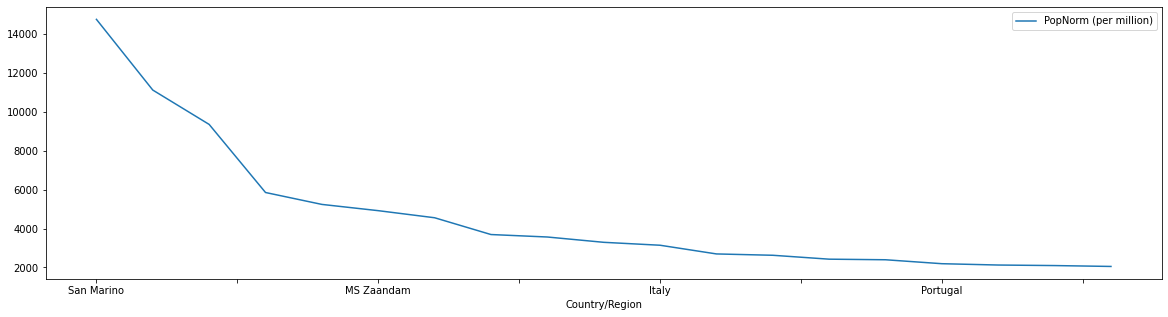

In [80]:
normalised.iloc[1:20].plot(figsize=(20,5))

## A Predictive Model

It is well understood that the spread of the virus follows an exponential pattern. This is because each infected person infects more than one new person on average, leading to exponential growth.  This is why the key to stopping the growth of the pandemic is to reduce the number of people infected by stopping contact and isolating infected poeple. 

An exponential curve has the equation $y = e^{mx}$. It can be converted to a linear relationship by taking the logarithm of each side: $log(y) = mx$.  This means that we can fit a linear regression model to the data as long as we take the log of the number of cases. 

### US
We select US which has a clear exponential curve and build a linear regression model to predict the log of the number of case. Later test how well the model fits the data. 

In [0]:
X = np.arange(1,len(grouped.T),1)
y = np.array(grouped.T['US'].iloc[:-1])
ln_y = np.log(y)

In [221]:
model_US = linear_model.LinearRegression()
X = np.reshape(X,(X.size,1))
model_US.fit(X,ln_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Report the MSE and $R^2$ value

In [222]:
from sklearn.metrics import mean_squared_error, r2_score

predicted = model_US.predict(X)
print("MSE:", mean_squared_error(ln_y, predicted))
print("R^2:", r2_score(ln_y, predicted))

MSE: 0.9686866768269421
R^2: 0.9549680753305183


Regression Equation:

In [206]:
print("y= e^(", model_US.coef_, "* x + ", model_US.intercept_,")")

y= e^( [0.1688335] * x +  -0.8645413544530856 )


Log-transformed linear regression plot

The straight line is the log-linear regression line passing through the log transformed population data points.

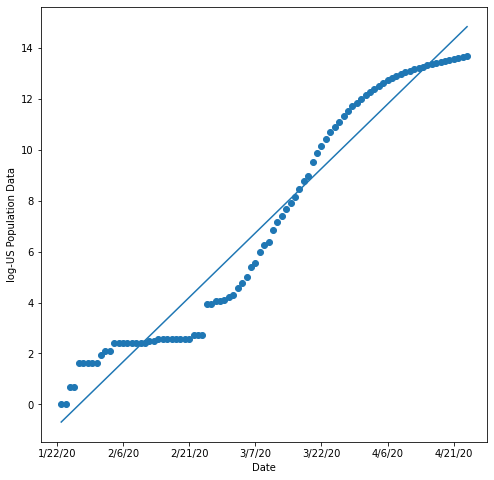

In [207]:
plt.figure(figsize=(8,8))
plt.xlabel("Date")
plt.ylabel("log-US Population Data")
plt.xticks(np.arange(len(grouped.T.index[:-1]),step=15),grouped.T.index[::15])
plt.plot([X.min(), X.max()], [model_US.coef_[0] * X.min() + model_US.intercept_, model_US.coef_[0] * X.max() + model_US.intercept_])  # single line
plt.scatter(X, ln_y)

Comparing the US population distribution with the simple model trained on mentioned data.

Text(0, 0.5, 'Population count')

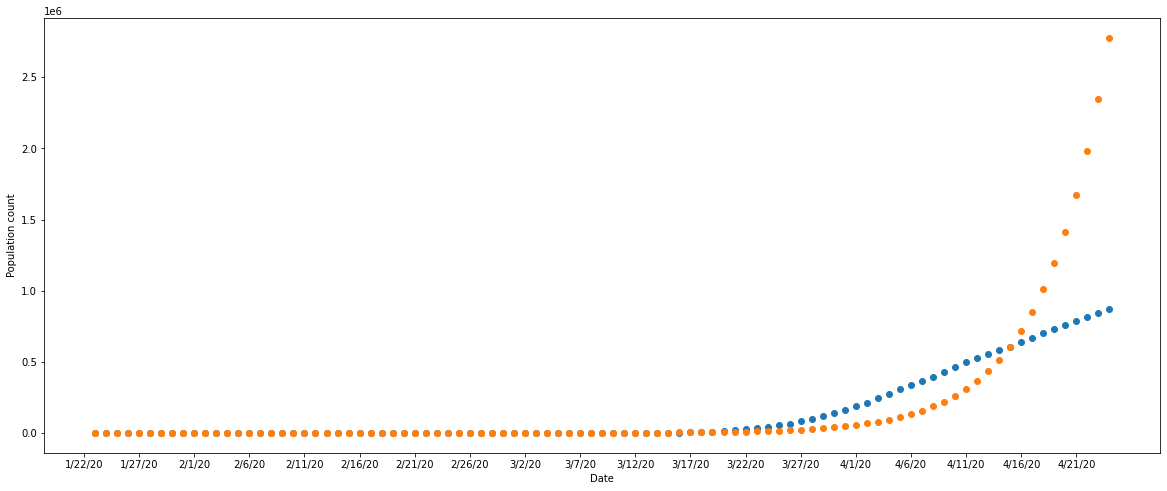

In [208]:
plt.figure(figsize=(20,8))
plt.scatter(X, y)
plt.scatter(X,np.exp(model_US.coef_ * X + model_US.intercept_))
plt.xticks(np.arange(len(grouped.T.index[:-1]),step=5),grouped.T.index[::5])
plt.xlabel("Date")
plt.ylabel("Population count")

### China


We now select the data from China. This should show some divergence from the model since they have managed to slow the growth of cases.   

In [0]:
X_china = np.arange(1,len(grouped.T),1)
y_china = np.array(grouped.T['China'].iloc[:-1])
ln_y_china = np.log(y_china)

We can show from the model that China's data does not show exponential growth

The straight line represents the model created from the US data, fitting the log-transformed China gets us the following graph.

The data points are clearly not exponential, the regression line harly passes through the dataset, there appears infact a straight line from around 21st February onwards.

Text(0, 0.5, 'log-China Population Data')

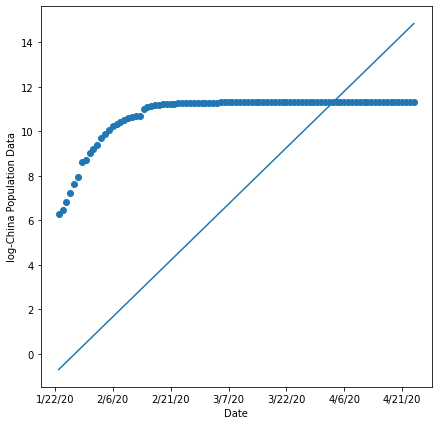

In [210]:
plt.figure(figsize=(7,7))
plt.plot([X_china.min(), X_china.max()], [model_US.coef_[0] * X_china.min() + model_US.intercept_, model_US.coef_[0] * X_china.max() + model_US.intercept_])  # single line
plt.scatter(X_china, ln_y_china)
plt.xticks(np.arange(len(grouped.T.index[:-1]),step=15),grouped.T.index[::15])
plt.xlabel("Date")
plt.ylabel("log-China Population Data")

The following statistics supports the fact that the china data is clearly not exponential. (Note the huge MSE value)

In [217]:
from sklearn.metrics import mean_squared_error, r2_score

X_china = np.reshape(X_china,(X_china.size,1))
predicted = model_US.predict(X_china)
print("MSE:", mean_squared_error(y_china, predicted))
print("R^2:", r2_score(y_china, predicted))

MSE: 5056452973.246876
R^2: -5.687451124764806


Answering the question: 
If China had not acted to stop the virus, how many cases would there be now according to this simple model? 


The model is built on the US data, the predictions for the China would be a huge exponential increase.


In [212]:
print("As of",grouped.T.index[-2],"according to the US model, China would have",round(np.exp(model_US.coef_ * X_china[-1][0] + model_US.intercept_)[0]),"cases")

As of 4/23/20 according to the US model, China would have 2777256.0 cases


The following graph should show the reason for the huge exponential increase in the value of cases that was predicted by the US model for China.

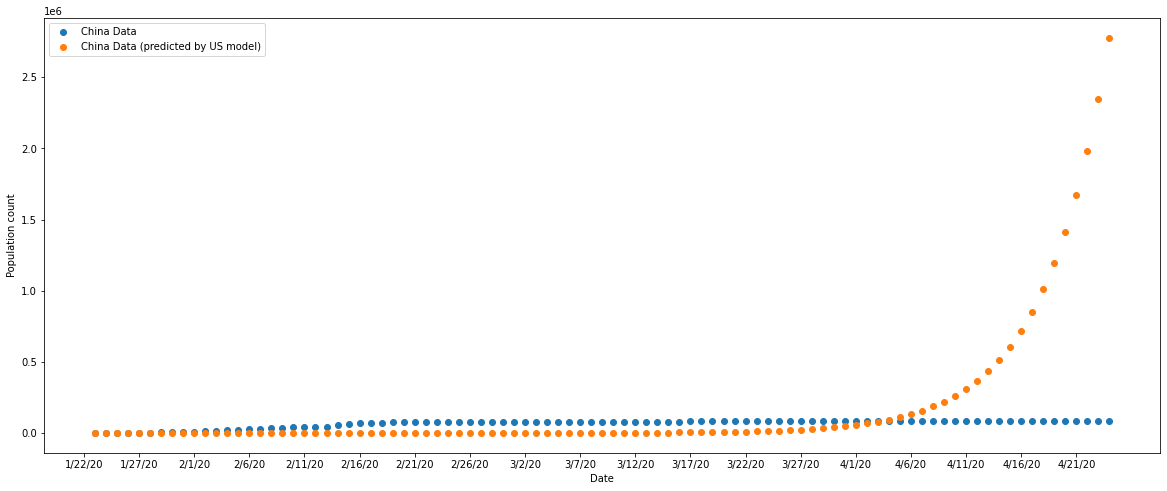

In [215]:
plt.figure(figsize=(20,8))
plt.scatter(X_china, y_china)
plt.scatter(X_china,np.exp(model_US.coef_ * X_china + model_US.intercept_))
plt.xticks(np.arange(len(grouped.T.index[:-1]),step=5),grouped.T.index[::5])
plt.xlabel("Date")
plt.ylabel("Population count")
plt.legend(['China Data','China Data (predicted by US model)'])

## Using the model as a metric for other countries

We create a dataframe that holds the $R^2$ values of each country. The model based on the US data is used and data from each country is taken as input for prediction, and in turn giving us $R^$ values. 

We try to understand if we can identify countries where the virus is under control and those where it is not based on the US model

In [0]:
control_country = pd.DataFrame(columns=['R^2 value'],index=grouped.index)

for country in grouped.index:
  X_country = np.arange(1,len(grouped.T),1)
  y_country = np.array(grouped.T[country].iloc[:-1])
  ln_y_country = np.log(y_country)
  
  X_country = np.reshape(X_country,(X_country.size,1))
  predicted = model_US.predict(X_country)
  control_country.loc[country,'R^2 value'] = r2_score(y_country, predicted)

The lower the $R^2$ value the more controlled the country is, this however is not a safe metric, the model only judges whether the data distribution of each country matches that of US also based on the dates. A country that had an outbreak earlier or much later would give us biased results, claiming that the cases are in control when they're not.


The model is therefore not a good metric

In [246]:
control_country.sort_values(['R^2 value'])

,R^2 value
Country/Region,
Yemen,-519.427
South Sudan,-23.4843
Sao Tome and Principe,-20.1747
Papua New Guinea,-10.8339
Western Sahara,-9.10833
...,...
Angola,0.520276
Dominica,0.53386
Mongolia,0.542149


## Optional Improved Predictive Model


The US data has clearly seen some changes since the announcement of the assignment. This is just a work in progress model that trains on data from around end of May, the date at which there has been a linear increase in number of cases as of 25th April 

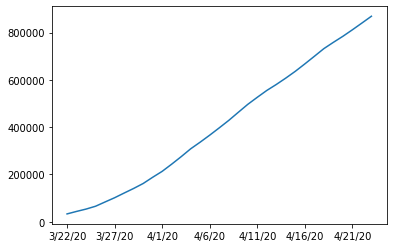

In [186]:
grouped.T['US'].iloc[60:-1].plot()

In [0]:
X = np.arange(1,len(grouped.T)-60,1)
y = np.array(grouped.T['US'].iloc[60:-1])

In [184]:
improved = linear_model.LinearRegression()
X = np.reshape(X,(X.size,1))
improved.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [185]:
from sklearn.metrics import mean_squared_error, r2_score

predicted = improved.predict(X)
print("MSE:", mean_squared_error(y, predicted))
print("R^2:", r2_score(y, predicted))

MSE: 462667349.7154026
R^2: 0.9934459155362645


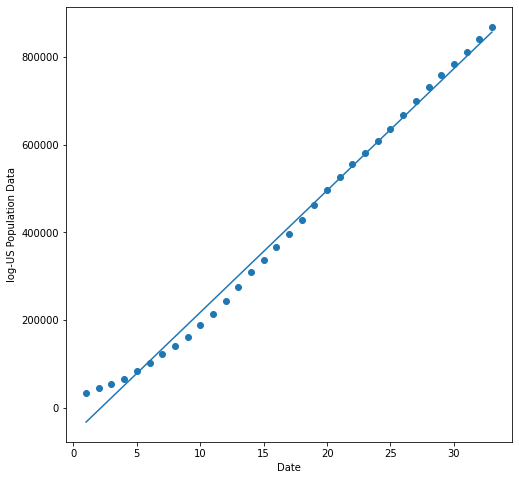

In [188]:
plt.figure(figsize=(8,8))
plt.xlabel("Date")
plt.ylabel("log-US Population Data")
plt.plot([X.min(), X.max()], [improved.coef_[0] * X.min() + improved.intercept_, improved.coef_[0] * X.max() + improved.intercept_])  # single line
plt.scatter(X, y)

Text(0, 0.5, 'Population count')

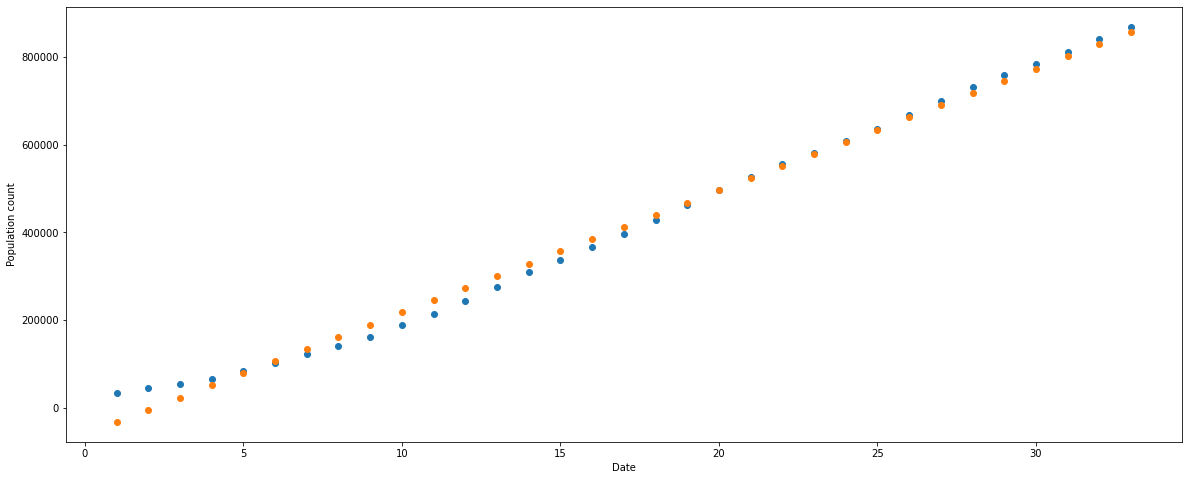

In [195]:
plt.figure(figsize=(20,8))
plt.scatter(X, y)
plt.scatter(X,improved.coef_ * X + improved.intercept_)
plt.xlabel("Date")
plt.ylabel("Population count")

### Using the model on China data 

In [0]:
X_china = np.arange(1,len(grouped.T)-60,1)
y_china = np.array(grouped.T['China'].iloc[60:-1])

Text(0, 0.5, 'log-China Population Data')

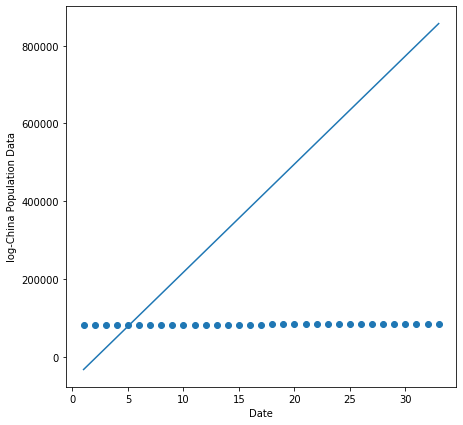

In [193]:
plt.figure(figsize=(7,7))
plt.plot([X_china.min(), X_china.max()], [improved.coef_[0] * X_china.min() + improved.intercept_, improved.coef_[0] * X_china.max() + improved.intercept_])  # single line
plt.scatter(X_china, y_china)
plt.xlabel("Date")
plt.ylabel("log-China Population Data")

In [200]:
print("As of",grouped.T.index[-2],"according to the US model, China would have",round((improved.coef_ * X_china[-1] + improved.intercept_)[0]),"cases")

As of 4/23/20 according to the US model, China would have 856924.0 cases
